In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
from metagov import at2df # Small custom wrapper functions for the Airtable library

In [3]:
# Output settings
SAVE = True
SAVEDIR = 'tmp'
sns.set(rc={"figure.figsize":(5, 5)})
sns.set(font_scale=1.25)
kwargs_svg = {'format': 'svg', 'bbox_inches': 'tight', 'facecolor': 'white'}
kwargs_png = {'format': 'png', 'bbox_inches': 'tight', 'dpi': 600}

In [4]:
at = at2df.get_airtable()

In [5]:
df = at2df.get_table_as_df(at, 'Constitutional Model')
df_projects = at2df.get_table_as_df(at, 'Projects', kwargs={'view': 'DAO ecosystem projects'})
df['On-chain components key'] = df['On-chain components']
df['On-chain components'] = df['On-chain components key'].apply(
    lambda values: [df_projects.at[v, 'Project name'] for v in values] if isinstance(values, list) else np.nan)

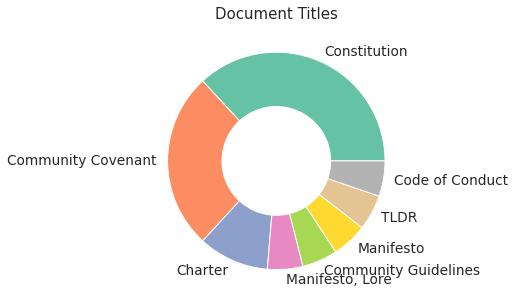

In [6]:
# Plot document titles
documentTitles = df['doctit'].value_counts()
labels = [', '.join(t) for t in documentTitles.index]
fig = plt.pie(documentTitles, labels=labels, colors=sns.color_palette("Set2"), wedgeprops=dict(width=0.5))
plt.title('Document Titles')

fname = f"{SAVEDIR}/constitution_model_documentTitles"
plt.savefig(f"{fname}.png", **kwargs_png)

In [7]:
def plot_coded_column(df_all, col, label='', orient='h'):
    """Plot frequency of unique list items for coded columns
    Handle columns with list values differently from columns with single values"""
    
    df = df_all.copy(deep=True)
    isListCol = any([isinstance(d, list) for d in df[col]])
    
    if isListCol:
        # Make sure all values in column are lists
        df[col] = df[col].apply(lambda d: d if isinstance(d, list) else [])

        # One-hot encode column of lists
        mlb = MultiLabelBinarizer(sparse_output=True)
        df_onehot = pd.DataFrame.sparse.from_spmatrix(
            mlb.fit_transform(df[col]),
            index=df.index,
            columns=mlb.classes_)

        # Get count for each unique item
        df_sum = pd.DataFrame(df_onehot.sum()).sort_values(0, axis=0, ascending=False).transpose()
    else:
        df_sum = pd.DataFrame(df[col].value_counts()).transpose()
    
    # Plot bar chart of unique list items
    plt.plot()
    sns.barplot(data=df_sum, orient=orient)
    
    # Formatting
    if orient == 'h':
        plt.ylabel(label)
        plt.xlabel('Count')
        if not isListCol:
            plt.xlim((0, df_sum.sum().sum() + 1))
    else:
        plt.ylabel('Count')
        plt.xlabel(label)
        if not isListCol:
            plt.ylim((0, df_sum.sum().sum() + 1))
    
    fname = f"{SAVEDIR}/constitution_model_{label}"
    plt.savefig(f"{fname}.png", **kwargs_png)

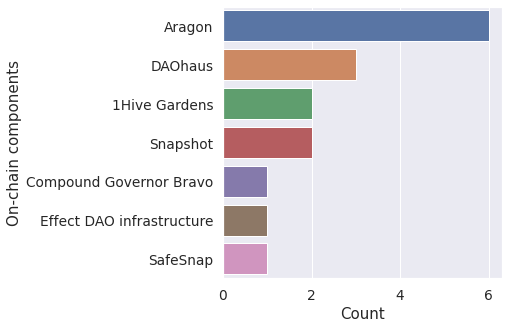

In [8]:
plot_coded_column(df, 'On-chain components', label='On-chain components')

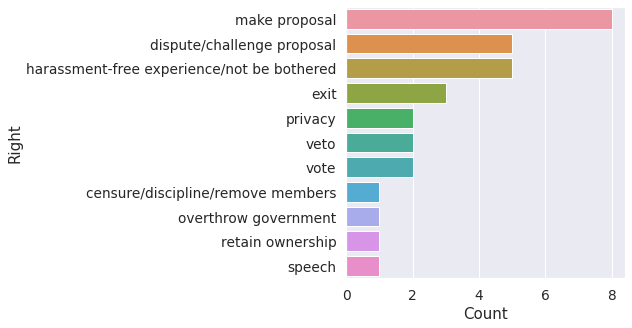

In [9]:
plot_coded_column(df, 'rights_code', label='Right')

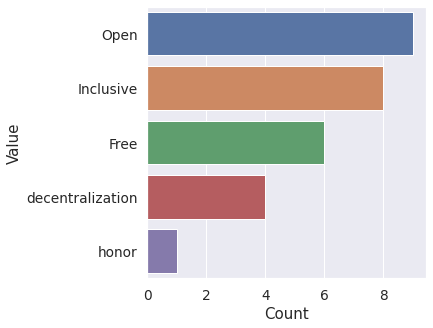

In [10]:
plot_coded_column(df, 'values_code', label='Value')

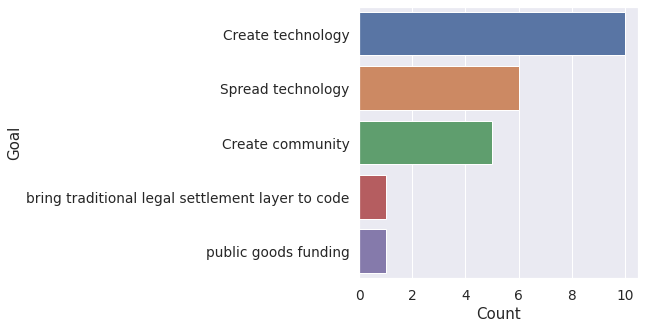

In [11]:
plot_coded_column(df, 'goals_code', label='Goal')

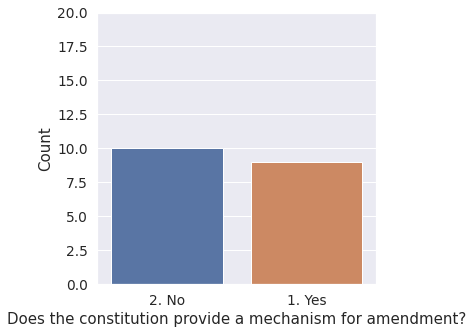

In [12]:
plot_coded_column(df, 'amend', label='Does the constitution provide a mechanism for amendment?', orient='v')

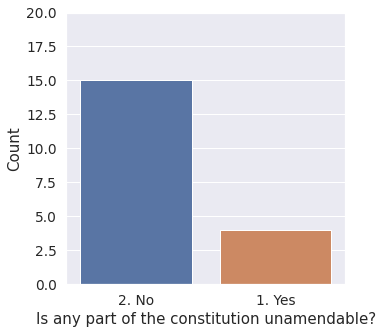

In [13]:
plot_coded_column(df, 'unamend', label='Is any part of the constitution unamendable?', orient='v')

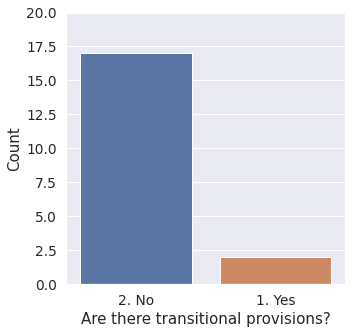

In [14]:
plot_coded_column(df, 'transprov', label='Are there transitional provisions?', orient='v')